<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Sian's_1D_CNN_baseline_(%2Bquant).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IoT-23 Data preprocessing
- Collection
- Cleaning
- Encoding
- Scaling
- Normalisation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Step 1: Data Collection
data_file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/IoT-23 8GB Dataset/Malware-Project/BigDataset/IoTScenarios/CTU-IoT-Malware-Capture-1-1/bro/conn.log.labeled'

# Read the file
df = pd.read_csv(
    data_file_path,
    sep="\t",
    comment="#",
    header=None,
    names=[
        "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto",
        "service", "duration", "orig_bytes", "resp_bytes", "conn_state",
        "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts",
        "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "label"
    ]
)

print("\nInitial sample:")
print(df.head().to_string())

# Step 2: Data Cleaning
# Convert timestamp to datetime
df["ts"] = pd.to_datetime(df["ts"], unit="s", errors='coerce')

# Drop non-informative or redundant columns
df.drop(columns=['uid', 'id.orig_h', 'id.resp_h', 'local_orig', 'local_resp', 'history'], inplace=True)

# Replace '-' with NaN for consistent handling
df.replace('-', np.nan, inplace=True)

# Drop rows where critical numeric fields are missing
df.dropna(subset=[
    'duration', 'orig_bytes', 'resp_bytes', 'id.orig_p', 'id.resp_p',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'
], inplace=True)

# Convert appropriate columns to numeric types
numeric_columns = [
    'duration', 'orig_bytes', 'resp_bytes', 'id.orig_p', 'id.resp_p',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'missed_bytes'
]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Encode categorical columns
categorical_columns = ['proto', 'conn_state', 'service']
for col in categorical_columns:
    df[col] = df[col].astype(str)  # Ensure strings
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert label to binary (malicious=1, benign=0)
df['label'] = df['label'].apply(lambda x: 1 if 'Malicious' in str(x) else 0)

# Drop any rows still containing NaN
df.dropna(inplace=True)

print("\nCleaned sample:")
print(df.head().to_string())
print("\nData types and nulls:")
print(df.info())
# print("\nStatistics:")
# print(df.describe().to_string())


# --- Split features and labels ---
X = df.drop(columns=['label', 'ts']).values  # Drop label and timestamp
y = df['label'].values

# --- Normalize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- Add counts of malware and benign logs ---
total_logs = len(df)
malware_logs = df['label'].sum()  # since malware=1
benign_logs = total_logs - malware_logs

print(f"\nTotal logs: {total_logs}")
print(f"Malware logs: {malware_logs}")
print(f"Benign (non-malicious) logs: {benign_logs}")



Initial sample:
             ts                 uid        id.orig_h  id.orig_p        id.resp_h  id.resp_p proto service  duration orig_bytes resp_bytes conn_state local_orig local_resp  missed_bytes history  orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes                                            label
0  1.525880e+09  CUmrqr4svHuSXJy5z7  192.168.100.103      51524   65.127.233.163         23   tcp       -  2.999051          0          0         S0          -          -             0       S          3            180          0              0  (empty)   Malicious   PartOfAHorizontalPortScan
1  1.525880e+09  CH98aB3s1kJeq6SFOc  192.168.100.103      56305    63.150.16.171         23   tcp       -         -          -          -         S0          -          -             0       S          1             60          0              0  (empty)   Malicious   PartOfAHorizontalPortScan
2  1.525880e+09   C3GBTkINvXNjVGtN5  192.168.100.103      41101     111.40.23.49         23   tcp    

# Data reshaping for 1D CNN input

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Reshape the data for 1D CNN input
# --- 1D CNN expects input shape: (samples, timesteps, features) ---
# Here: timesteps = number of features, features = 1 (per timestep)
X_1dcnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

#Step 2: Train/Validation/Test Split
# --- Split into Train/Val/Test ---
# Split test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X_1dcnn, y, test_size=0.2, random_state=42, stratify=y)
# Split validation set (20% of remaining)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# --- Final Shape Confirmation ---
print("1D CNN input shape:", X_1dcnn.shape)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Labels - Train: {np.bincount(y_train)}, Val: {np.bincount(y_val)}, Test: {np.bincount(y_test)}")

Train shape: (135966, 13, 1), Val shape: (33992, 13, 1), Test shape: (42490, 13, 1)
1D CNN input shape: (212448, 13, 1)
Train: (135966, 13, 1), Val: (33992, 13, 1), Test: (42490, 13, 1)
Labels - Train: [ 14821 121145], Val: [ 3705 30287], Test: [ 4631 37859]


#1D CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

#Step 3: Define the 1D CNN Model

# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)

# Build model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
# model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Train, Evaluate (Test) & Visualize 1D CNN

Epoch 1/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9777 - loss: 0.0895 - val_accuracy: 0.9878 - val_loss: 0.0622
Epoch 2/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9912 - loss: 0.0447 - val_accuracy: 0.9914 - val_loss: 0.0438
Epoch 3/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9925 - loss: 0.0409 - val_accuracy: 0.9872 - val_loss: 0.0602
Epoch 4/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9922 - loss: 0.0421 - val_accuracy: 0.9919 - val_loss: 0.0439
Epoch 5/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9920 - loss: 0.0426 - val_accuracy: 0.9921 - val_loss: 0.0427
Epoch 6/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9938 - loss: 0.0356 - val_accuracy: 0.9931 - val_loss: 0.0383
Epoch 7/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9936 - loss: 0.0355 - val_accuracy: 0.9941 - val_loss: 0.0676
Epoch 8/10
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9940 - loss: 0.033

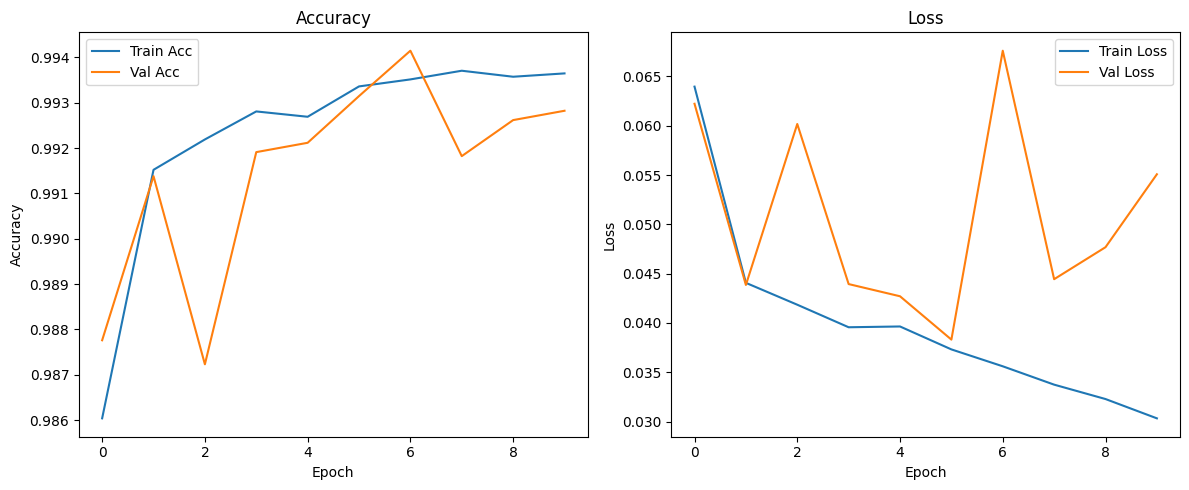

In [ ]:
import matplotlib.pyplot as plt

#Step 4: Train the Model

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Step 5: Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")


# Step 6: Plot Accuracy and Loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to 0 or 1

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: print as table
print("Confusion Matrix:")
print(cm)

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as malware): {fp}")
print(f"False Negatives (Malware missed): {fn}")
print(f"True Positives (Malware correctly identified): {tp}")

# Accuracy score
print("sklearn accuracy:", accuracy_score(y_test, y_pred))

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

1328/1328 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Confusion Matrix:
[[ 4357   274]
 [    0 37859]]

True Negatives (Benign correctly classified): 4357
False Positives (Benign misclassified as malware): 274
False Negatives (Malware missed): 0
True Positives (Malware correctly identified): 37859
sklearn accuracy: 0.9935514238644387

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.94      0.97      4631
   Malicious       0.99      1.00      1.00     37859

    accuracy                           0.99     42490
   macro avg       1.00      0.97      0.98     42490
weighted avg       0.99      0.99      0.99     42490



# 1D CNN Quant model

In [ ]:
import tensorflow as tf
import numpy as np
import os
from sklearn.utils import shuffle

# --- STEP 1: Balance the sample set to 40% benign, 60% malware ---
def balance_sample_data(X_train, y_train, benign_ratio=0.4):
    benign_X = X_train[y_train == 0]
    malware_X = X_train[y_train == 1]

    total = min(len(benign_X) + len(benign_X), 100000)
    benign_n = int(benign_ratio * total)
    malware_n = total - benign_n

    benign_X_sampled = benign_X[np.random.choice(len(benign_X), benign_n)]
    malware_X_sampled = malware_X[np.random.choice(len(malware_X), malware_n)] #ISSUE?

    X_bal = np.vstack((benign_X_sampled, malware_X_sampled))
    y_bal = np.array([0]*benign_n + [1]*malware_n)

    return shuffle(X_bal, y_bal, random_state=42)

# Apply balancing to training data
X_sample, y_sample = balance_sample_data(X_train, y_train, benign_ratio=0.4)

# Ensure 1D shape (samples, timesteps, 1)
X_sample = X_sample.reshape((X_sample.shape[0], X_sample.shape[1], 1))

# --- STEP 2: Define representative dataset for quantization ---
def representative_dataset():
    for i in range(1000):
        index = np.random.randint(0, X_sample.shape[0]) #randomise choices from X_sample data to get a range of diverse samples (not just the first 1000)
        yield [X_sample[index:index+1].astype(np.float32)]

# --- STEP 3: Quantization function ---
def converter_quantization_model(model, model_name):
    os.makedirs('./models', exist_ok=True)

    # Save float32 optimized model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float32]
    converter.representative_dataset = representative_dataset
    tflite_model_float32 = converter.convert()
    with open(model_name + '_quant_float32.tflite', 'wb') as f:
        f.write(tflite_model_float32)

    # Save int8 quantized model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.int8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    converter.representative_dataset = representative_dataset
    tflite_model_int8 = converter.convert()
    with open(model_name + '_quant_int8.tflite', 'wb') as f:
        f.write(tflite_model_int8)

# --- STEP 4: Apply conversion ---
converter_quantization_model(model, './models/1Dcnn')


Saved artifact at '/tmp/tmpmzvn1ftb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 13, 1), dtype=tf.float32, name='keras_tensor_66')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132278918917456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278918917648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278918913616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278918918224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278918917072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278918917840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278918911888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278918913808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279277370256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132279277356816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278918916880: 

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


#Evaluate int8 1D CNN

In [ ]:
from tensorflow.lite.python.interpreter import Interpreter
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import time


def evaluate_tflite_model(tflite_path, X_test, y_test):
    #Load and Prepare TFLite Interpreter
    interpreter = Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    #Fetch input & output Tensor Details from the TensorFlow Lite Interpreter after the model is loaded and memory for its tensors is allocated.
    input_details = interpreter.get_input_details() #Input tensor: shape, dtype, index.
    output_details = interpreter.get_output_details() #Output tensor: shape, dtype, index, quantisation.

    #Store the tensor indices and data types for input/output
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']
    input_dtype = input_details[0]['dtype']
    output_dtype = output_details[0]['dtype']

    # Calculate Quantization Threshold
    output_scale, output_zero_point = output_details[0]['quantization']#Get quantization parameters for the output
    if output_dtype == np.int8:
        quantized_threshold = int(round(0.5 / output_scale + output_zero_point)) #Computes the int8 value that corresponds to 0.5 — the usual binary classification threshold for float.

    #Initializes empty lists to store predictions and timing
    predictions = []
    processing_times = []

    for i in range(len(X_test)):
        #input_data = np.expand_dims(X_test[i], axis=0).astype(input_dtype)#Prepare Input Tensor and Run Inference
        input_data = np.expand_dims(X_test[i], axis=0)

        if input_dtype == np.int8:
            input_scale, input_zero_point = input_details[0]['quantization']
            input_data = (input_data / input_scale + input_zero_point).astype(np.int8)
        else:
            input_data = input_data.astype(input_dtype)

        start_time = time.time()
        interpreter.set_tensor(input_index, input_data) #Loads input into the interpreter.
        interpreter.invoke() #Execute the model
        output = interpreter.get_tensor(output_index) #Gets the output tensor.
        processing_times.append(time.time() - start_time)

        # Handle prediction thresholding for float and int8 models
        if output_dtype == np.float32:
            pred = (output[0][0] > 0.5).astype(int)
        elif output_dtype == np.int8:
            pred = (output[0][0] > quantized_threshold).astype(int) #If int8, compare against precomputed quantized threshold
        else:
            raise ValueError(f"Unsupported output dtype: {output_dtype}")

        predictions.append(pred)

    #Evaluate Accuracy and Confusion Matrix
    acc = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    print(f"{tflite_path} Accuracy: {acc:.4f}")
    print(f"Avg inference time: {np.mean(processing_times)*1000:.2f} ms/sample")
    print("Confusion Matrix:")
    print(cm)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        print(f"\nTrue Negatives (Benign correctly classified): {tn}")
        print(f"False Positives (Benign misclassified as malware): {fp}")
        print(f"False Negatives (Malware missed): {fn}")
        print(f"True Positives (Malware correctly identified): {tp}")
    else:
        print("\nWarning: Confusion matrix is not 2x2 — check labels.")

# Execute evaluation function:
evaluate_tflite_model("./models/1Dcnn_quant_float32.tflite", X_test, y_test)
evaluate_tflite_model("./models/1Dcnn_quant_int8.tflite", X_test, y_test)


./models/1Dcnn_quant_float32.tflite Accuracy: 0.9936
Avg inference time: 0.01 ms/sample
Confusion Matrix:
[[ 4357   274]
 [    0 37859]]

True Negatives (Benign correctly classified): 4357
False Positives (Benign misclassified as malware): 274
False Negatives (Malware missed): 0
True Positives (Malware correctly identified): 37859
./models/1Dcnn_quant_int8.tflite Accuracy: 0.7995
Avg inference time: 0.01 ms/sample
Confusion Matrix:
[[ 4296   335]
 [ 8183 29676]]

True Negatives (Benign correctly classified): 4296
False Positives (Benign misclassified as malware): 335
False Negatives (Malware missed): 8183
True Positives (Malware correctly identified): 29676
